This notebook peforms a blind tip reconstruction using the gradient decent of the opening from noise-free image data

## load required packages and test data

In [1]:
using Flux
using Flux.Data: DataLoader
using Plots
using BSON: @save, @load
using Statistics
using Revise, MDToolbox

In [2]:
@load "prepare_test_data.bson" width height resolution radius angle param models tip surfs images images_randn

In [3]:
function translate_tip_peak(P)
    tip_xsiz, tip_ysiz = size(P)
    xc, yc = MDToolbox.compute_xc_yc(P)
    
    p_max, id = findmax(P)
    p_min = minimum(P)

    P_new = deepcopy(P)
    P_new .= p_min - p_max
    
    pxmin = max(1-xc, 1-id[1])
    pymin = max(1-yc, 1-id[2])
    pxmax = min(tip_xsiz-xc, tip_xsiz-id[1])
    pymax = min(tip_ysiz-yc, tip_ysiz-id[2])
    for px = pxmin:pxmax
        for py = pymin:pymax
            P_new[xc+px, yc+py] = P[id[1]+px, id[2]+py] - p_max
        end
    end
    return P_new
end

translate_tip_peak (generic function with 1 method)

In [4]:
all([true, true])

true

In [5]:
function translate_tip_mean(P)
    tip_xsiz, tip_ysiz = size(P)
    xc, yc = MDToolbox.compute_xc_yc(tip)

    p_min = minimum(P)
    weight_x = sum(P .- p_min, dims=2)[:]
    if all(weight_x .< 10.0^(-8))
        weight_x .= 1.0
    end
    id_x = round(Int, sum(weight_x .* collect(1.0:1.0:tip_xsiz)) / sum(weight_x))
    weight_y = sum(P .- p_min, dims=1)[:]
    if all(weight_y .< 10.0^(-8))
        weight_y .= 1.0
    end
    id_y = round(Int, sum(weight_y .* collect(1.0:1.0:tip_ysiz)) / sum(weight_y))

    p_max = maximum(P)
    P_new = deepcopy(P)
    P_new .= p_min .- p_max
    
    pxmin = max(1-xc, 1-id_x)
    pymin = max(1-yc, 1-id_y)
    pxmax = min(tip_xsiz-xc, tip_xsiz-id_x)
    pymax = min(tip_ysiz-yc, tip_ysiz-id_y)
    for px = pxmin:pxmax
        for py = pymin:pymax
            P_new[xc+px, yc+py] = P[id_x+px, id_y+py] .- p_max
        end
    end
    return P_new
end

translate_tip_mean (generic function with 1 method)

## Define Flux layers

In [6]:
struct IOpen
    P::AbstractArray
end

IOpen(height::Integer, width::Integer) = IOpen(zeros(Float64, height, width))

Flux.@functor IOpen (P,)

(m::IOpen)(image) = idilation(ierosion(image, m.P), m.P)

## loop over lambda

In [7]:
images_randn_copy = deepcopy(images)

lambdas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
loss_over_lambdas = []
P_over_lambdas = []

for lambda in lambdas
    @info lambda

    m = IOpen(9, 11)

    #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( -m.P .* log.(-m.P .+ eps(Float32)))
    #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( m.P.^2 )
    #loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn)) + lambda * sum( - m.P )
    loss(image_randn_copy, image_randn) = mean(Flux.Losses.mse.(m.(image_randn_copy), image_randn))

    ps = Flux.params(m)

    train_loader = Flux.Data.DataLoader((data=images_randn_copy[1:20], label=images_randn[1:20]), batchsize=1, shuffle=false);
    test_loader = Flux.Data.DataLoader((data=images_randn_copy[21:30], label=images_randn[21:30]), batchsize=1);

    #opt = ADAM(0.1)
    opt = ADAMW(1.0, (0.9, 0.999), lambda)

    loss_train = []
    loss_test = []

    for epoch in 1:100
        for (x, y) in train_loader
            gs = gradient(() -> loss(x, y), ps)
            Flux.Optimise.update!(opt, ps, gs)
            m.P .= min.(m.P, 0.0)
            m.P .= translate_tip_mean(m.P)
        end
        push!(loss_train, loss(images_randn_copy[1:20], images_randn[1:20]))
        push!(loss_test, loss(images_randn_copy[21:30], images_randn[21:30]))
    end

    push!(loss_over_lambdas, loss_train[end])
    push!(P_over_lambdas, m.P)
end

┌ Info: 1.0e-6
└ @ Main In[7]:8
┌ Info: 1.0e-5
└ @ Main In[7]:8
┌ Info: 0.0001
└ @ Main In[7]:8
┌ Info: 0.001
└ @ Main In[7]:8
┌ Info: 0.01
└ @ Main In[7]:8
┌ Info: 0.1
└ @ Main In[7]:8
┌ Info: 1.0
└ @ Main In[7]:8


In [8]:
loss_over_lambdas

7-element Vector{Any}:
  10.701116398211951
  10.663033571279739
  11.632778511382261
  30.918510944983108
 211.90484834564705
 302.7237738393037
 316.9464203566612

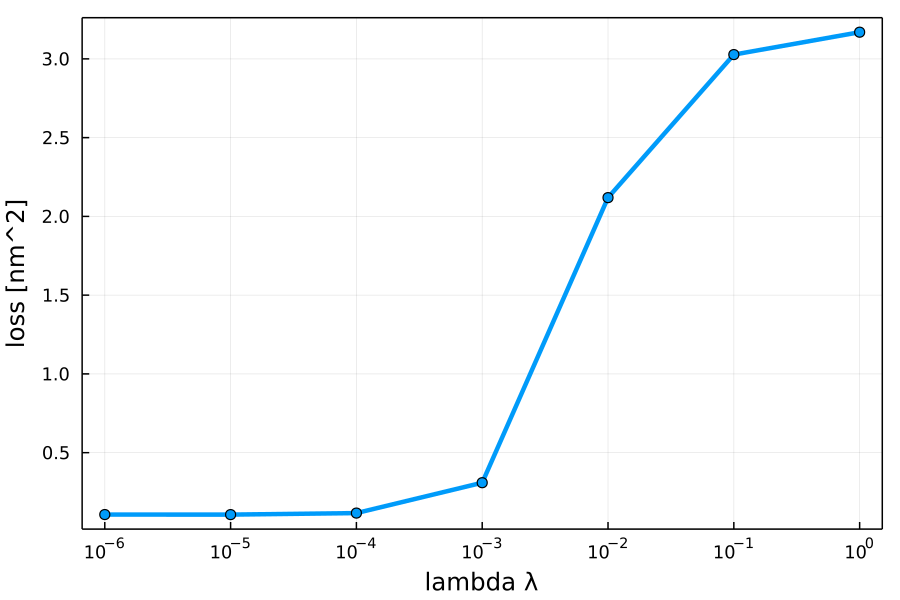

In [9]:
p = plot(lambdas[1:7], loss_over_lambdas / 100.0, xaxis=:log, framestyle = :box, xlabel="lambda λ", ylabel="loss [nm^2]", fontsize=35, label=nothing, linewidth=3.0, markershape=:circle, dpi=150, fmt=:png)

In [10]:
savefig(p, "blindtip_opening01.png")

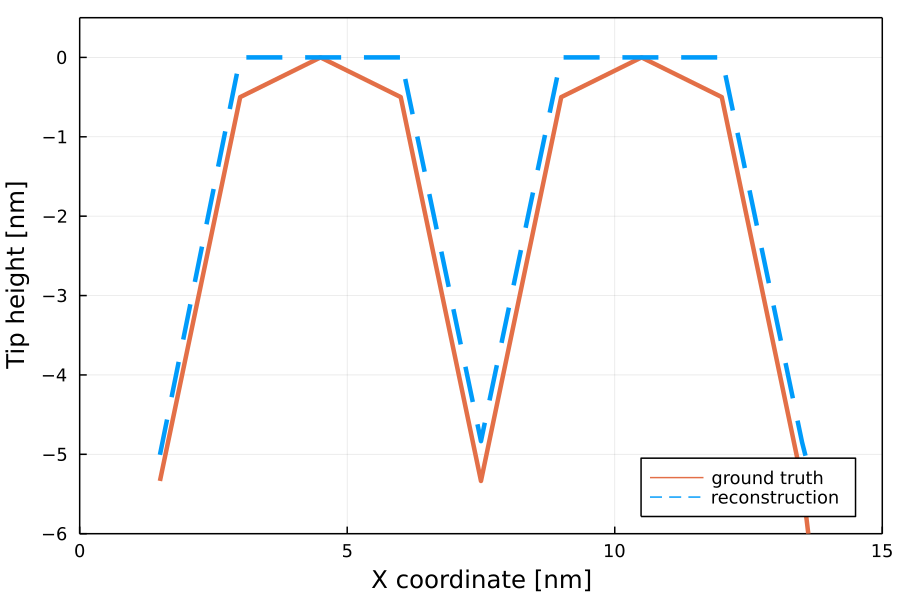

In [11]:
plot(collect(1:11) .* resolution / 10.0, tip[4, :] / 10.0, linewidth=3, label="ground truth", legend=:bottomright, color=2)
p = plot!((collect(1:11)) .* resolution / 10.0, translate_tip_mean(P_over_lambdas[3])[4, :] / 10.0, linewidth=3, linestyle=:dash, label="reconstruction", framestyle=:box, dpi=150, fmt=:png, color=1)
ylims!((-6, 0.5))
xlims!((0, 15))
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Tip height [nm]", fontsize=35)

In [12]:
savefig(p, "blindtip_opening02.png")

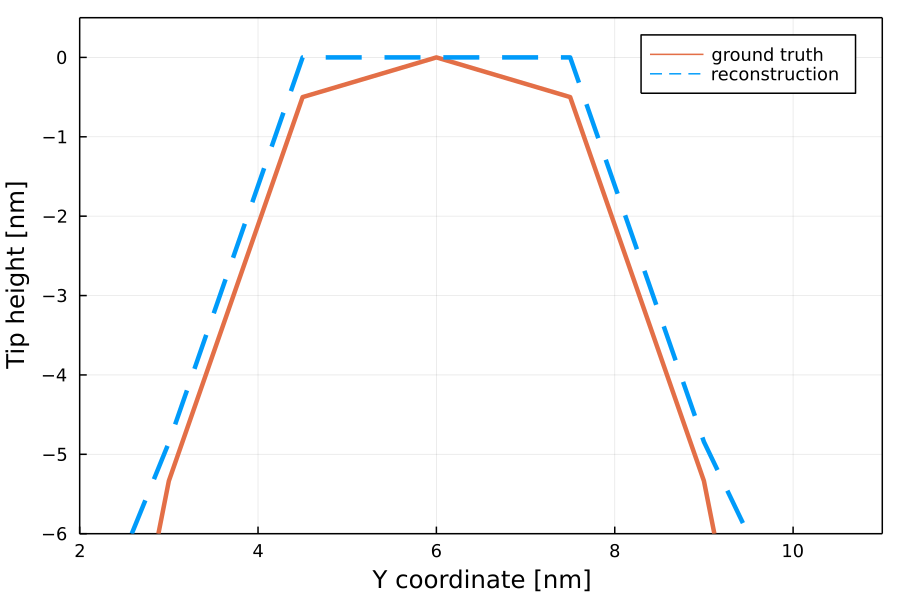

In [13]:
plot(collect(1:9) .* resolution / 10.0, tip[:, 3] / 10.0, linewidth=3, label="ground truth", color=2)
plot!(collect(1:9) .* resolution / 10.0, translate_tip_mean(P_over_lambdas[3])[:, 3] / 10.0, linewidth=3, linestyle=:dash, label="reconstruction", framestyle=:box, dpi=150, fmt=:png, color=1)
ylims!((-6, 0.5))
xlims!((2, 11))
xlabel!("Y coordinate [nm]", fontsize=35)
ylabel!("Tip height [nm]", fontsize=35)

In [14]:
savefig(p, "blindtip_opening03.png")

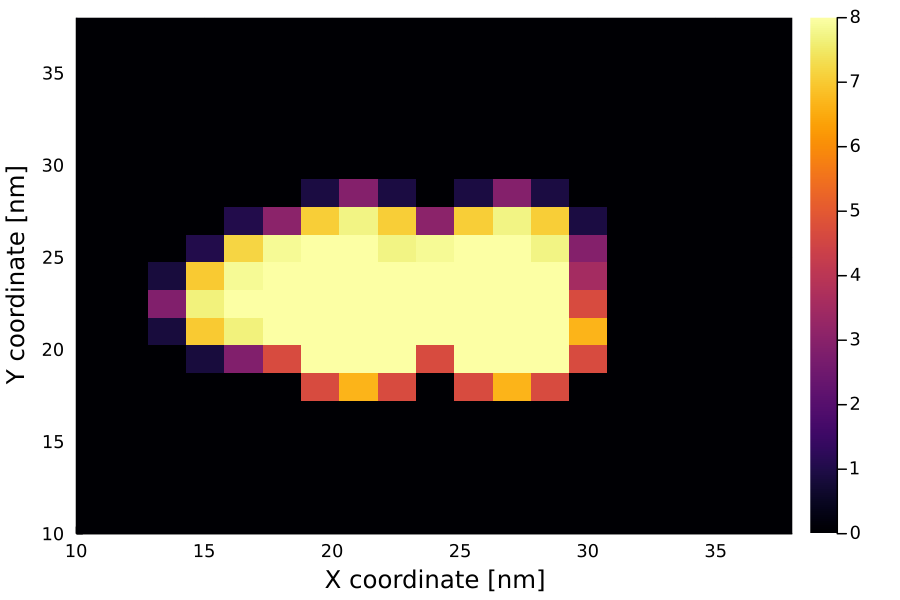

In [15]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, images[1] / 10.0, clim=(0, 8), dpi=150, fmt=:png)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 38)
ylims!(10, 38)

In [16]:
savefig(p, "blindtip_opening04.png")

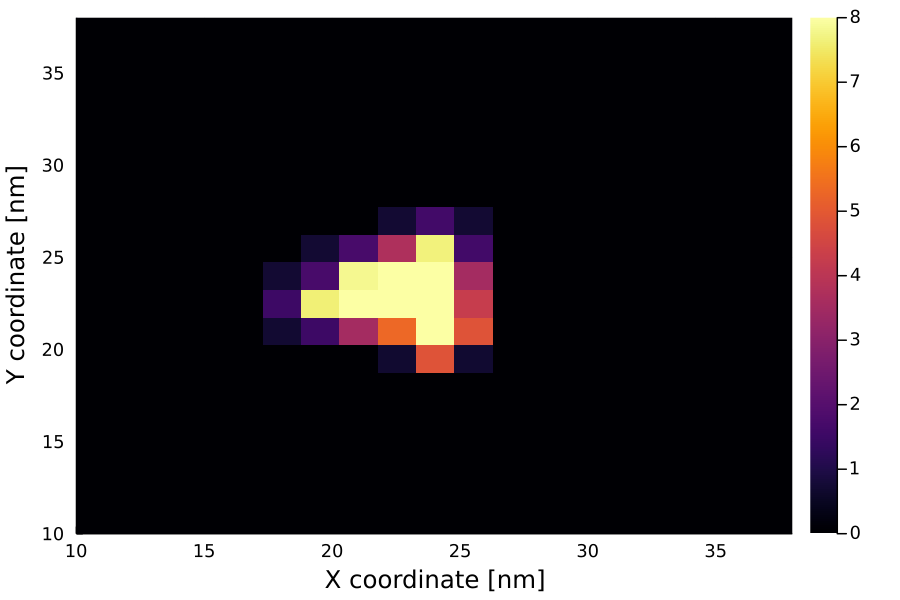

In [17]:
p = heatmap(collect(1:30) .* resolution / 10.0, collect(1:30) .* resolution / 10.0, ierosion(images[1], translate_tip_mean(P_over_lambdas[3])) / 10.0, clim=(0, 8), dpi=150, fmt=:png)
xlabel!("X coordinate [nm]", fontsize=35)
ylabel!("Y coordinate [nm]", fontsize=35)
xlims!(10, 38)
ylims!(10, 38)

In [18]:
savefig(p, "blindtip_opening05.png")

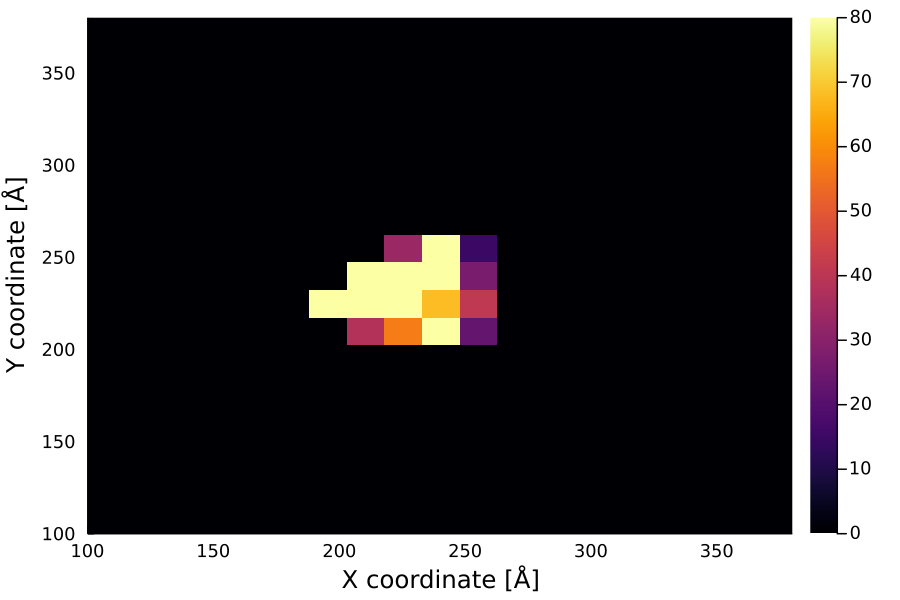

In [19]:
p = heatmap(collect(1:30) .* resolution, collect(1:30) .* resolution, surfs[1], clim=(0, 80), dpi=150, fmt=:png)
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
xlims!(100, 380)
ylims!(100, 380)

In [20]:
savefig(p, "blindtip_opening06.png")